In [ ]:
pip install diffimg

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import os
from glob2 import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageStat
import diffimg

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
train_dir = '/content/drive/MyDrive/影像處理/dataset/nomal_data/train'
test_dir = '/content/drive/MyDrive/影像處理/dataset/nomal_data/test'
an_dir = '/content/drive/MyDrive/影像處理/data1/anomal_data'

In [ ]:
image_size = (100, 100)
batch_size = 64
datagen=ImageDataGenerator(rescale=1./ 255)
train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        color_mode='grayscale',
                                        class_mode='input',
                                        shuffle=True)

test_gen = datagen.flow_from_directory(test_dir,
                                       target_size=image_size,
                                       batch_size=batch_size,
                                       color_mode='grayscale',
                                       class_mode='input')
an_gen = datagen.flow_from_directory(an_dir,
                                     target_size=image_size,
                                     batch_size=batch_size,
                                     color_mode='grayscale',
                                     class_mode='input')

Found 4120 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


In [ ]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/影像處理/CNN", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1, save_freq='epoch')#save_weights_only=True, 
]

In [ ]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = tf.keras.Sequential([
            # layers.Conv2D(1, 3, activation='relu', padding='same'),
            layers.Conv2D(8, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu'),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(32, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(64, 3, activation='relu'),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(1024, activation='relu'),
            layers.Reshape((4,4,64)),
            layers.Conv2DTranspose(64, 3, activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, activation='relu'),
            layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, 3, activation='relu', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


cnn = CNN()
cnn.build((64,100,100,1))
cnn.encoder.summary()
cnn.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (64, 50, 50, 8)           80        
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 48, 48, 16)          1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (64, 24, 24, 16)          2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (64, 12, 12, 16)          2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (64, 6, 6, 32)            4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (64, 4, 4, 64)            18496     
_________________________________________________________________
flatten (Flatten)            (64, 1024)                0

In [ ]:
cnn.compile(optimizer='adam', loss='mse')
history=cnn.fit(train_gen,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_data=test_gen,
                callbacks = my_callbacks
                )

Epoch 1/200
65/65 [==============================] - 1411s 21s/step - loss: 0.1887 - val_loss: 0.0911

Epoch 00001: val_loss improved from inf to 0.09111, saving model to /content/drive/MyDrive/影像處理/CNN
INFO:tensorflow:Assets written to: /content/drive/MyDrive/影像處理/CNN/assets
Epoch 2/200
65/65 [==============================] - 6s 96ms/step - loss: 0.0885 - val_loss: 0.0865

Epoch 00002: val_loss improved from 0.09111 to 0.08648, saving model to /content/drive/MyDrive/影像處理/CNN
INFO:tensorflow:Assets written to: /content/drive/MyDrive/影像處理/CNN/assets
Epoch 3/200
65/65 [==============================] - 6s 96ms/step - loss: 0.0859 - val_loss: 0.0852

Epoch 00003: val_loss improved from 0.08648 to 0.08518, saving model to /content/drive/MyDrive/影像處理/CNN
INFO:tensorflow:Assets written to: /content/drive/MyDrive/影像處理/CNN/assets
Epoch 4/200
65/65 [==============================] - 6s 96ms/step - loss: 0.0851 - val_loss: 0.0845

Epoch 00004: val_loss improved from 0.08518 to 0.08455, saving m

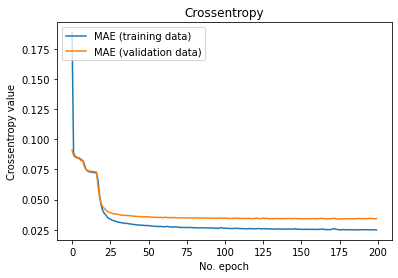

In [ ]:
plot1 = plt.figure(1)
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Crossentropy')
plt.ylabel('Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")


plt.show()

In [ ]:
def show_imgs(xs, decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(xs[i].squeeze())
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].squeeze())
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

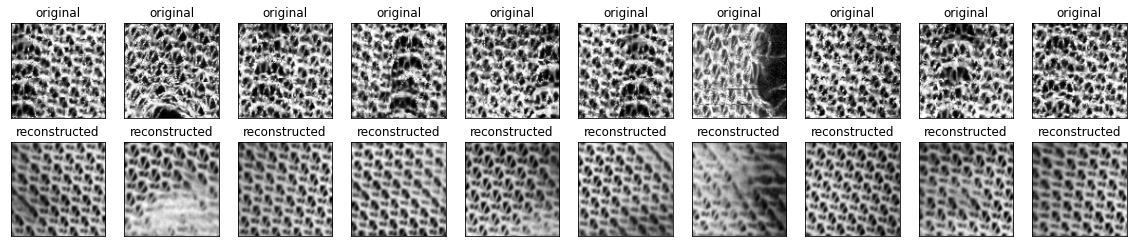

In [ ]:
xs, ys = next(an_gen)
encoded_imgs = cnn.encoder(xs).numpy()
decoded_imgs = cnn.decoder(encoded_imgs).numpy()
K.int_shape(decoded_imgs.squeeze())
show_imgs(xs, decoded_imgs)




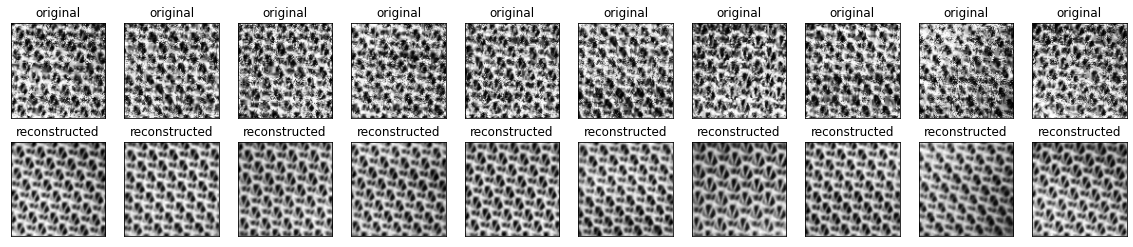

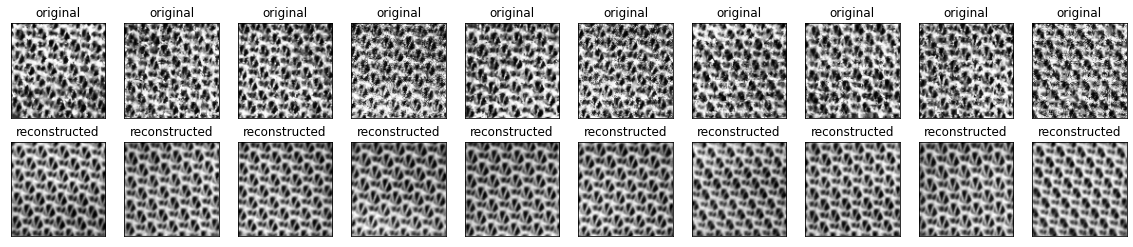

In [ ]:
xs, ys = next(test_gen)
encoded_imgs = cnn.encoder(xs).numpy()
decoded_imgs = cnn.decoder(encoded_imgs).numpy()
K.int_shape(decoded_imgs.squeeze())
show_imgs(xs, decoded_imgs)

xs, ys = next(train_gen)
encoded_imgs = cnn.encoder(xs).numpy()
decoded_imgs = cnn.decoder(encoded_imgs).numpy()
K.int_shape(decoded_imgs.squeeze())
show_imgs(xs, decoded_imgs)

In [32]:
# %load "test/test.py"  
import cv2
import tensorflow as tf
import numpy as np
from os import listdir
from os.path import join
import time

model = tf.keras.models.load_model('/content/drive/MyDrive/影像處理/CNN')

def cv2tf_img(img):
    img = np.asarray(img)
    img = np.expand_dims(img, axis=-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def is_anomal(r, x, threshold):
    # print(np.square(r-x).mean())
    return np.square(r-x).mean() >= threshold
  

def predict(frame, threshold):
    stride = 50
    size = 100
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameTemp = frame.copy()
    cv2.rectangle(frameTemp, (0, 0), (800, 600), (255, 255, 255),-1)
    h, w = img.shape
    num_row = ((h - size) // stride) + 1
    num_col = ((w - size) // stride) + 1

    for i in range(num_row):
        for j in range(num_col):
            eq_img = cv2.equalizeHist(img[i * stride: size + (i * stride), j * stride: size + (j * stride)])
            # eq_img = (img[i * stride: size + (i * stride), j * stride: size + (j * stride)])
            inp_img = cv2tf_img(eq_img)
            # print(inp_img.shape)
            re_img = model.predict(tf.stack([inp_img]))
            # print(re_img.shape)
            st = 10
            for r in range(10):
              for c in range(10):
                re1 = re_img[0, r*st: st+(r*st), c*st: st+c*st,]
                # print(re1.shape)
                inp1 = inp_img[r*st: st+(r*st), c*st: st+c*st]
                # print(inp1.shape)
                if is_anomal(re1, inp1, threshold):
                  cv2.rectangle(frameTemp, (j * stride + c*st, i * stride+r*st), (st+c*st + (j * stride), st+(r*st) + (i * stride)), (0, 0, 0), -1) 

    frame = frameTemp  
    return frame

if __name__ == '__main__':
    fld = '/content/drive/MyDrive/影像處理/error/'
    # threshold = 0.115
    threshold = 0.16
    for i, f in enumerate(listdir(fld)):
        frame = cv2.imread(join(fld, f))
        frame = cv2.resize(frame, (800, 600), interpolation=cv2.INTER_AREA)
        time_start = time.time()
        frame = predict(frame, threshold)
        time_end = time.time()
        print(f'img-{i} cost time : {time_end - time_start} sec')
      
        cv2.imwrite(f'/content/drive/MyDrive/影像處理/error_result/{i}.bmp', frame)


img-0 cost time : 12.360832691192627 sec
img-1 cost time : 12.793722152709961 sec


In [ ]:
def read_img(f):
    img = cv2.imread(f, 0)
    img = np.asarray(img)
    img = np.expand_dims(img,axis=-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

anomal_img = read_img('/content/drive/MyDrive/影像處理/data1/anomal_data/anomal/36.bmp')
nomal_img = read_img('/content/drive/MyDrive/影像處理/dataset/nomal_data/train/train_data/0.bmp')
anomal_img2 = read_img('/content/drive/MyDrive/影像處理/data1/anomal_data/anomal/51.bmp')
# anomal_img = read_img('/content/drive/MyDrive/影像處理/dataset/nomal_data/train/train_data/texture_video_1.png')
# anomal_img2 = read_img('/content/drive/MyDrive/影像處理/dataset/nomal_data/train/train_data/texture_video_1000.png')

model = tf.keras.models.load_model('/content/drive/MyDrive/影像處理/CNN')

re_nomal_img = model.predict(tf.stack([nomal_img]))
re_anomal_img = model.predict(tf.stack([anomal_img]))
re_anomal_img2 = model.predict(tf.stack([anomal_img2]))

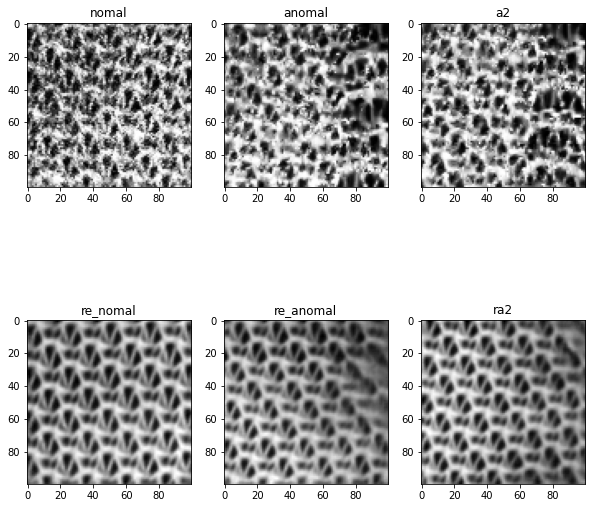

In [ ]:
titles = ['nomal', 'anomal', 'a2', 're_nomal', 're_anomal', 'ra2', ]
imgs = [nomal_img, anomal_img, anomal_img2, re_nomal_img[0], re_anomal_img[0], re_anomal_img2[0]]

plt.figure(figsize=(10, 10))
for i,(title, img) in enumerate(zip(titles, imgs)):
    # print(img.shape)
    plt.subplot(2,3, i +1)
    plt.imshow(img[:,:,0], cmap='gray')
    plt.title(title)

In [ ]:
def cal_acc(losses, threshold, is_nomal):
    losses = np.array(losses)
    if is_nomal:
        return np.count_nonzero(losses <= threshold) / len(losses)
    else:
        return np.count_nonzero(losses >= threshold) / len(losses)


# print(f'anomal data predict acc: {cal_acc(anomal_losses, threshold, is_nomal=False)}')
# print(f'nomal train data predict acc: {cal_acc(train_loss, threshold, is_nomal=True)}')
# print(f'nomal test data predict acc: {cal_acc(test_loss, threshold, is_nomal=True)}')
# print(f'nomal val data predict acc: {cal_acc(val_loss, threshold, is_nomal=True)}')

In [ ]:
threshold = 0.05
def predict(r, x):
    print(np.square(r - x).mean())
    if np.square(r - x).mean() >= threshold:
        return 'anomal'
    else:
        return 'nomal'

print(f'nomal img, predict is : {predict(nomal_img, re_nomal_img)}')
print(f'anomal img, predict is : {predict(anomal_img, re_anomal_img)}')
print(f'anomal img, predict is : {predict(anomal_img2, re_anomal_img2)}')

0.034159098
nomal img, predict is : nomal
0.059193574
anomal img, predict is : anomal
0.07180397
anomal img, predict is : anomal
